# 03_01 SARIMAX Modelling

SARIMAX stands for __Seasonal AutoRegressive Integrated Moving Average with eXogenous regressors model__ and combines multiple Components:
  * Autoregressive Term (AR)
  * Moving Average Term (MA)
  
Both terms have the goal to decrease the lagged forecast error to converge the prediction to the true time series.
  
On top of that SARIMAX is adding a Seasonal component and an eXogenous regressor model which allows us to use additional features for an Multivariate Time Series Prediction. Actually I'm not really using the Seasonal Feature, but it seems ARIMAX and SARIMAX are implemented into the same class in statsmodels.

I will fit the model __without paying respect to Stationarity or Seasonality of my input Time Series__ as I got only really poor results on experimenting with it, whereas without processing my data for being stationary I got better results. I'm aware of the absolute necessity of Stationarity for Time Series in Autoregressive Model Fitting but I guess for a Multivariate Scenario I need to do some more Autoregression specific Data Preprocessing. 

Moreover I will paying attention to Features that have a maximum of timeshift into the past for beeing able of getting the biggest future forecasting.

## Extended Analysis

I will put my focus on optimizing the used features as I have many of them. I will try on as many feature combinations as possible to find the best prediction in Cross Validation. Therefore it isn't necessary to get the best RSME, but it should catch as many signals from the real data:

  * [03_02_model_ARIMAX_optimization](https://github.com/herrfeder/DataScientist/blob/master/Project_05_Capstone_Stock_Chart_Analysis/03_2_model_ARIMAX_optimization.py)
  * [03_03_investigate_feature_optimization](https://github.com/herrfeder/DataScientist/blob/master/Project_05_Capstone_Stock_Chart_Analysis/03_3_investigate_feature_optimization.ipynb)

#### Resources
  * Simple ARIMA Explanation: https://towardsdatascience.com/arima-simplified-b63315f27cbc
  * Good Overview about ARIMA Models: https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/
  * How to prepare Explanatory Variables for Multivariate SARIMAX Model: https://www.kaggle.com/viridisquotient/arimax
  * How to prepare Time Series data for Multivariate SARIMAX Model: https://www.machinelearningplus.com/time-series/time-series-analysis-python/

In [2]:
import data_prep_helper
import statsmodels.api as sm
import pandas as pd
from math import sqrt
from sklearn.metrics import mean_squared_error
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


## Data Preprocessing and Train-Test-Split

In [3]:
do = data_prep_helper.ShiftChartData(chart_col=["Price","High","Low"])

corr_df = do.chart_df


corr_df = corr_df.resample('D').interpolate()

#creating the train and validation set
train = corr_df[:1500]
valid = corr_df[1500:]

train = do.get_causal_const_shift(train)

valid = do.get_causal_const_shift(valid)

## Model Fitting

I choosed the following Features in the first step from the drawn conclusions from the previous notebooks and in the second step with some Try-And-Error to find a good combination that returns a promising prediction Time Series: 

In [4]:
features = ['bitcoin_Google_Trends_prev_month',
                  'cryptocurrency_Google_Trends_prev_month',
                  'alibaba_High_prev_month',
                  'amazon_High_prev_month',
                  'economy_pos_sents_prev_month']

sl_train = train['bitcoin_Price']
exog_train = train[features]
    
# As I'm waiving the stationarity I can explicitly give this as an argument to the model init
arimax = sm.tsa.statespace.SARIMAX(sl_train, 
                                   exog=exog_train,
                                   enforce_invertibility=False, 
                                   enforce_stationarity=False, 
                                   freq='D').fit()
print(arimax.summary())

                               SARIMAX Results                                
Dep. Variable:          bitcoin_Price   No. Observations:                 1469
Model:               SARIMAX(1, 0, 0)   Log Likelihood              -11600.702
Date:                Sun, 19 Apr 2020   AIC                          23215.404
Time:                        19:27:15   BIC                          23252.445
Sample:                    02-08-2015   HQIC                         23229.218
                         - 02-15-2019                                         
Covariance Type:                  opg                                         
                                              coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
bitcoin_Google_Trends_prev_month           -0.2126      0.159     -1.338      0.181      -0.524       0.099
cryptocurrency_Google_Trends_prev_month     

## Prediction against Training Set

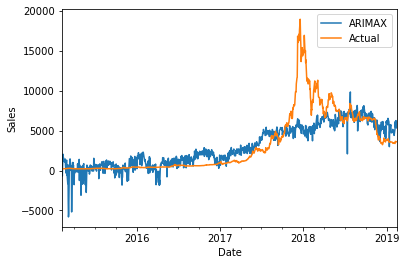

In [5]:

exog = train[features]
forecast =  arimax.predict( dynamic=True, exog=exog)
actual = train["bitcoin_Price"]

forecast.plot()
actual.plot()
plt.legend(['ARIMAX', 'Actual'])
plt.ylabel('Sales');



## Forecast against Test Set

In [6]:
exog = valid[features]

In [7]:
forecast = arimax.get_forecast(steps=len(valid), exog=exog)

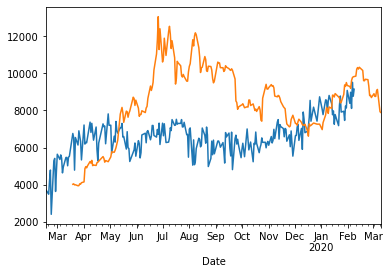

In [8]:
forecast.predicted_mean.plot()
valid["bitcoin_Price"].plot()

In [9]:
sqrt(mean_squared_error(forecast.predicted_mean, valid["bitcoin_Price"]))

2613.3169663012336

In [10]:
arimax.save("models/sarimax_5_feat_month.pkl")

#### Conclusions from SARIMAX Modelling

Regarding the ranges of my resulting prediction and real plot the resulting RMSE (root-mean-squared-error) value is a good first result and may will be used for prediction and catching good forecasting signals and triggers.

We can see, that the resulting prediction is very noisy. That's due to the high volatility in the Google Trends and Sentiment Time Series.

## Cross Validation

S_0_CORR: 0.4518358060400048
S_0_RMSE: 5145.586752980478
S_1_CORR: 0.7565615912588124
S_1_RMSE: 2140.736671897923
S_2_CORR: 0.4364914782796356
S_2_RMSE: 2922.740108721743


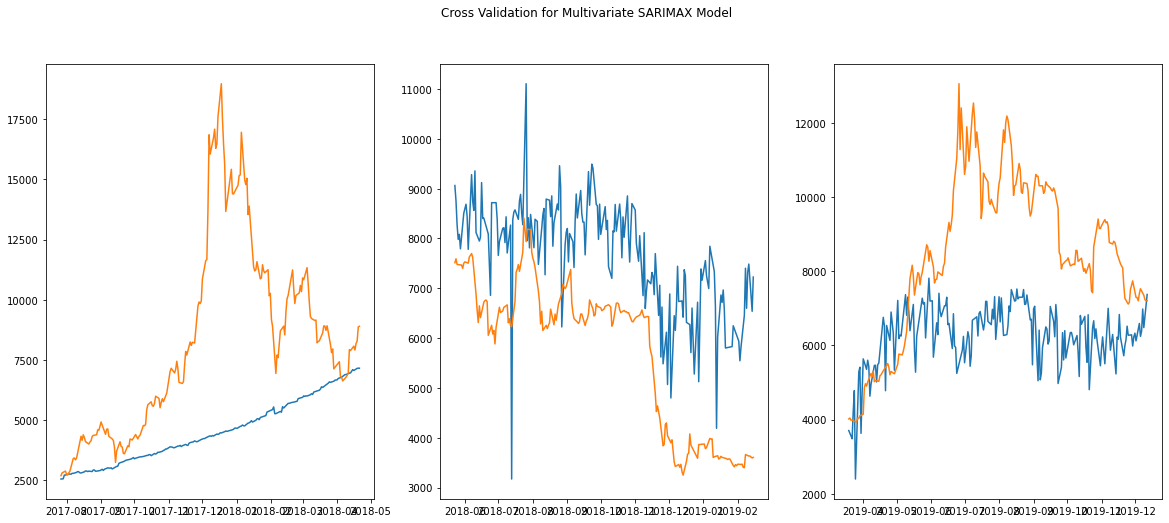

In [11]:
split_index=0
result_dict={}
fig, ax = plt.subplots(1, 3, figsize=(20,8))

for train, test in do.gen_return_splits():
    exog_s1i1 = train[features]
    exog = test[features]
    s1i1 = train['bitcoin_Price']
    arimax = sm.tsa.statespace.SARIMAX(s1i1, exog=exog_s1i1,
                               enforce_invertibility=False, 
                               enforce_stationarity=False, 
                               freq='D').fit(disp=0)

    forecast = arimax.get_forecast(steps=len(test), exog=exog)
    arimax.save("models/sarimax_5_feat_month_S{}.pkl".format(str(split_index+1)))
    result_dict["S_{}_CORR".format(split_index)] = np.corrcoef(forecast.predicted_mean,test["bitcoin_Price"].values)[0][1]
    result_dict["S_{}_RMSE".format(split_index)] = sqrt(mean_squared_error(forecast.predicted_mean, test["bitcoin_Price"]))

    ax[split_index].plot(test.index, forecast.predicted_mean)
        
    ax[split_index].plot(test.index, test["bitcoin_Price"])
    fig.suptitle("Cross Validation for Multivariate SARIMAX Model")
    
    split_index = split_index + 1

for key, val in result_dict.items():
    print("{}: {}".format(key, val))
    
    
    

#### Conclusions from SARIMAX Cross Validation

We can see:
  * the first split doesn't have enough training data for drawing a reasonable prediction. Nearly the first half of the Bitcoin History is really steady and without volatile movements, therefore the resulting prediction looks like that.
  * the second split looks better, it's really noisy because of the Google Trend and Sentiment Data (maybe smoothing before) but we can see clearly the trend and the peaks of the real data in our prediction.
  * the third split shows a even better prediction, whereby some of the volatile movements can be seen in the prediction as well and some are mirrored. I guess this is due to some negative correlations between Sentiments and the Bitcoin Chart.
  
This is good to go, to use it for forecasting.

## Extended Analysis
  * [03_02_model_ARIMAX_optimization](https://github.com/herrfeder/DataScientist/blob/master/Project_05_Capstone_Stock_Chart_Analysis/03_2_model_ARIMAX_optimization.py)
  * [03_03_investigate_feature_optimization](https://github.com/herrfeder/DataScientist/blob/master/Project_05_Capstone_Stock_Chart_Analysis/03_3_investigate_feature_optimization.ipynb)